## Setup

In [19]:
# change into the src directory
import git
import os

repo = git.Repo('.', search_parent_directories=True)
os.chdir(repo.working_tree_dir)

In [20]:
from tapas_gmm.policy.models.tpgmm import ModelType, TPGMM, ReconstructionStrategy, FittingStage, InitStrategy, _xdx_to_tangent, TPGMMConfig, AutoTPGMMConfig, AutoTPGMM, FrameSelectionConfig, DemoSegmentationConfig, CascadeConfig
# import lovely_tensors as lt
# lt.monkey_patch()
from lovely_numpy import lo
import matplotlib.pyplot as plt

import pathlib
#from pbdlib.utils.jupyter_utils import *
import numpy as np

from conf._machine import data_naming_config as machine_data_naming_config
from tapas_gmm.dataset.demos import Demos, PartialFrameViewDemos
import tapas_gmm.policy.models.tpgmm
from tapas_gmm.utils.misc import load_scene_data, DataNamingConfig
from tapas_gmm.utils.logging import setup_logger  # noqa: F401
from tapas_gmm.viz.gmm import plot_log_map_quaternions, plot_hmm_transition_matrix

%matplotlib inline

%load_ext autoreload
%autoreload 2

data_root = pathlib.Path(machine_data_naming_config.data_root).resolve()
data_root = data_root.parent / data_root.stem

np.set_printoptions(precision=2)

plt.style.use('default')

from IPython.display import HTML
from matplotlib import rc
rc('animation', html='jshtml')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
task = "BlockDrawerBlueGrab"
path = data_root / task / "demos"

data_config = DataNamingConfig(
    feedback_type=None,
    task=None,
    data_root=None,
    path=path,
)

scene_data = load_scene_data(data_config)
print(scene_data.sample_data_point_with_ground_truth(cam="wrist"))

SingleCamSceneObservation(
    action=Tensor(shape=torch.Size([7]), device=cpu, dtype=torch.float32, is_shared=False),
    depth=Tensor(shape=torch.Size([256, 256]), device=cpu, dtype=torch.float32, is_shared=False),
    ee_pose=Tensor(shape=torch.Size([7]), device=cpu, dtype=torch.float32, is_shared=False),
    extr=Tensor(shape=torch.Size([4, 4]), device=cpu, dtype=torch.float32, is_shared=False),
    feedback=Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=False),
    intr=Tensor(shape=torch.Size([3, 3]), device=cpu, dtype=torch.float32, is_shared=False),
    mask=Tensor(shape=torch.Size([256, 256]), device=cpu, dtype=torch.uint8, is_shared=False),
    object_poses=TensorDict(
        fields={
            obj000: Tensor(shape=torch.Size([7]), device=cpu, dtype=torch.float32, is_shared=False),
            obj001: Tensor(shape=torch.Size([7]), device=cpu, dtype=torch.float32, is_shared=False),
            obj002: Tensor(shape=torch.Size([7]), device=cpu, dtype

In [22]:
gt_pose_config = {}

gt_kp_config = {
    'encoder_name': 'demos_keypoints_gt_encoder-world',
    'cam': 'static',
}

kp_config = {
    'encoder_name': 'demos_vit_keypoints_encoder',
    'encoding_name': 'gtcopy',
}


In [23]:
observations = scene_data.get_demos(**gt_pose_config)
print(observations[0].keys())
print(observations[0])
n_obs = len(observations)

demo_meta_data = {
    'path': path
}

data_kwargs = dict(
    meta_data=demo_meta_data,
    add_init_ee_pose_as_frame=True,
    add_world_frame=False,
    frames_from_keypoints=False,
    kp_indeces=None,
    enforce_z_up=False,
    modulo_object_z_rotation=False,
    make_quats_continuous=True
)

demos = Demos(observations, **data_kwargs)
print(demos)

_LazyStackedTensorDictKeysView(['action', 'cameras', 'ee_pose', 'feedback', 'gripper_state', 'joint_pos', 'joint_vel', 'object_poses', 'object_states'],
    include_nested=False,
    leaves_only=False)
SceneObservation(
    action=Tensor(shape=torch.Size([160, 7]), device=cpu, dtype=torch.float32, is_shared=False),
    cameras=LazyStackedTensorDict(
        fields={
            _order: CameraOrder(
                order=('wrist',),
                batch_size=torch.Size([160]),
                device=None,
                is_shared=False),
            wrist: SingleCamObservation(
                depth=Tensor(shape=torch.Size([160, 256, 256]), device=cpu, dtype=torch.float32, is_shared=False),
                extr=Tensor(shape=torch.Size([160, 4, 4]), device=cpu, dtype=torch.float32, is_shared=False),
                intr=Tensor(shape=torch.Size([160, 3, 3]), device=cpu, dtype=torch.float32, is_shared=False),
                rgb=Tensor(shape=torch.Size([160, 3, 256, 256]), device=cpu, dt

In [24]:
tpgmm_config = TPGMMConfig(
    n_components=10,
    model_type=ModelType.HMM,
    use_riemann=True,
    add_time_component=True,
    add_action_component=False,
    position_only=True,
    add_gripper_action=True,
    reg_shrink=1e-2,
    reg_diag=2e-4,
    reg_diag_gripper=2e-2,
    reg_em_finish_shrink=1e-2,
    reg_em_finish_diag=2e-4,
    reg_em_finish_diag_gripper=2e-2,
    trans_cov_mask_t_pos_corr=False,
    em_steps=50,
    fix_first_component=False,
    fix_last_component=False,
    reg_init_diag=5e-4,  # 5
    heal_time_variance=False,
)

frame_selection_config = FrameSelectionConfig(
    init_strategy=InitStrategy.TIME_BASED,
    fitting_actions=(FittingStage.INIT,),
    rel_score_threshold=0.5,
    use_bic=False,
    drop_redundant_frames=False,
)

demos_segmentation_config = DemoSegmentationConfig(
    gripper_based=False,
    distance_based=False,
    velocity_based=True,
    repeat_final_step=50,
    repeat_first_step=0,
    components_prop_to_len=True,
    min_n_components=3,
    velocity_threshold=0.0004,
    max_idx_distance=8,
    min_end_distance=30,
    min_len=8
)

cascade_config = CascadeConfig(
    kl_keep_time_dim=True,
    kl_keep_rotation_dim=False,
)

auto_tpgmm_config = AutoTPGMMConfig(
    tpgmm=tpgmm_config,
    frame_selection=frame_selection_config,
    demos_segmentation=demos_segmentation_config,
    cascade=cascade_config,
)

In [25]:
atpgmm = AutoTPGMM(auto_tpgmm_config)


2025-07-22 01:19:01.119 | INFO     |  Fitting AutoTPGMM
2025-07-22 01:19:01.120 | INFO     |  Segmenting trajectories


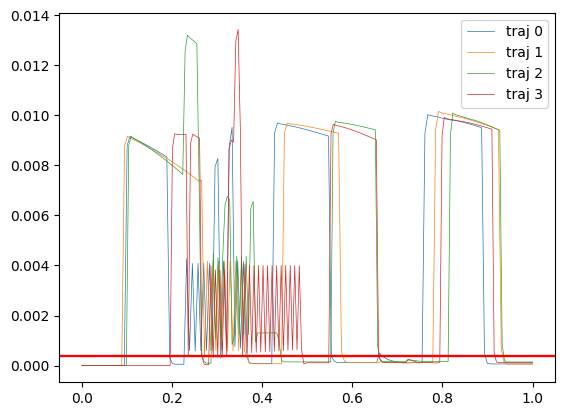

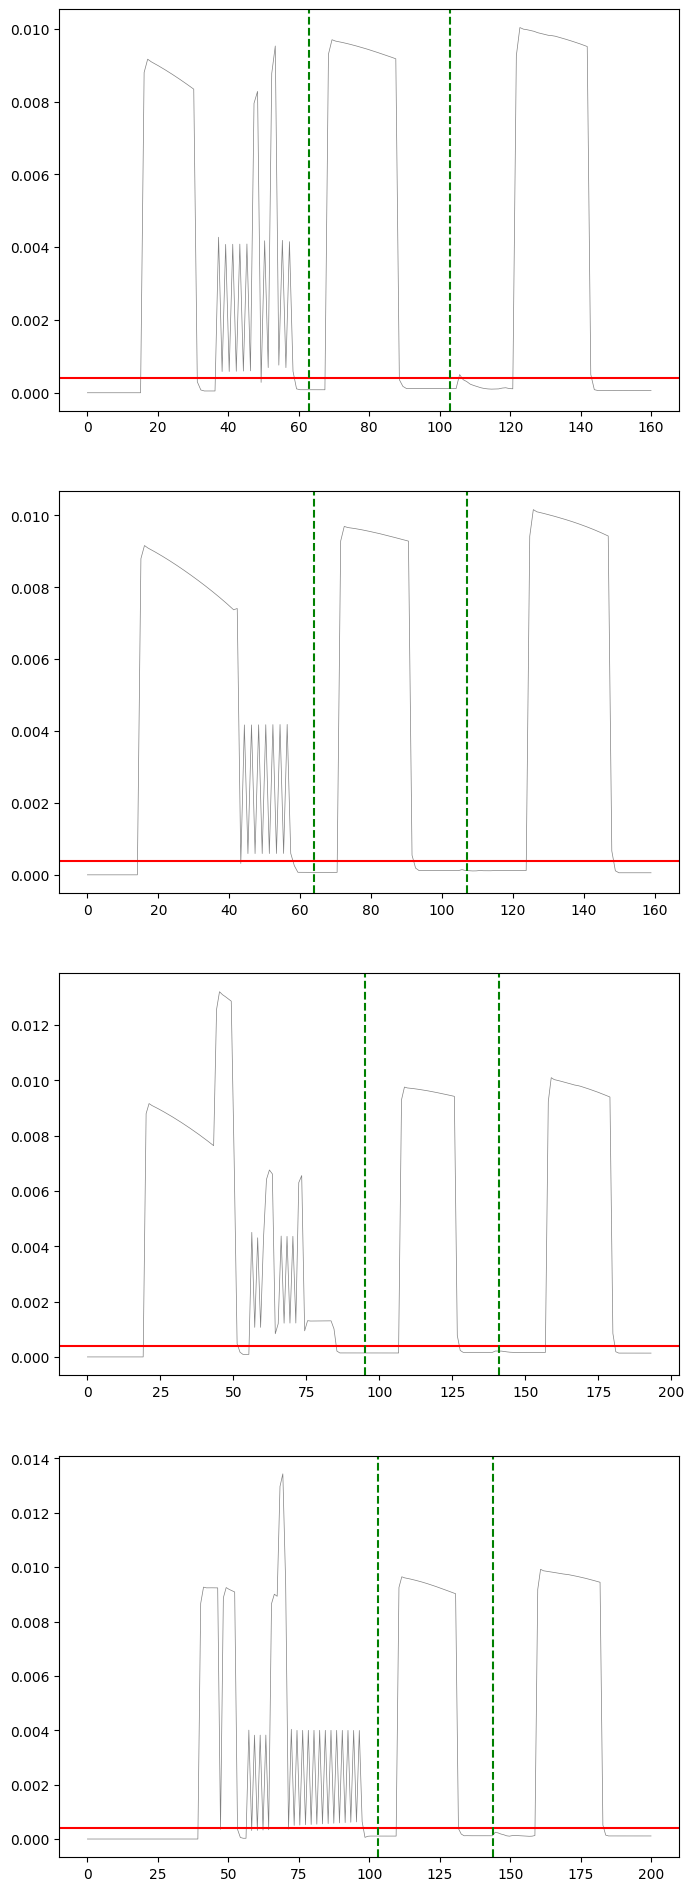

2025-07-22 01:19:01.863 | INFO     |  Creating segement of demos.
2025-07-22 01:19:01.870 | INFO     |  Creating segement of demos.
2025-07-22 01:19:01.876 | INFO     |  Creating segement of demos.
2025-07-22 01:19:01.883 | INFO     |  ... created 3 segments
2025-07-22 01:19:01.883 | INFO     |    Fitting candidate frame 1/10
2025-07-22 01:19:01.883 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-22 01:19:01.907 | INFO     |    Fitting candidate frame 2/10
2025-07-22 01:19:01.908 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-22 01:19:01.946 | INFO     |    Fitting candidate frame 3/10
2025-07-22 01:19:01.947 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-22 01:19:01.970 | INFO     |    Fitting candidate frame 4/10
2025-07-22 01:19:01.971 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-22 01:19:01.995 | INFO     |    Fitting candidate frame 5/10
2025-07-22 01:19:01.996 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-22 01:19:02.025 | INFO     |    Fitting candidate frame 6/10
2025-07-22 01:19:02.025 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-22 01:19:02.048 | INFO     |    Fitting candidate frame 7/10
2025-07-22 01:19:02.049 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-22 01:19:02.073 | INFO     |    Fitting candidate frame 8/10
2025-07-22 01:19:02.074 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-22 01:19:02.100 | INFO     |    Fitting candidate frame 9/10
2025-07-22 01:19:02.100 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-22 01:19:02.125 | INFO     |    Fitting candidate frame 10/10
2025-07-22 01:19:02.125 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-22 01:19:02.154 | INFO     |  obj007     score (rel):     -0 (0.098)
2025-07-22 01:19:02.155 | INFO     |  Creating partial frame view of demos.
2025-07-22 01:19:02.157 | INFO     |    Fitting candidate frame 1/10
2025-07-22 01:19:02.157 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-22 01:19:02.182 | INFO     |    Fitting candidate frame 2/10
2025-07-22 01:19:02.182 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-22 01:19:02.214 | INFO     |    Fitting candidate frame 3/10
2025-07-22 01:19:02.215 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-22 01:19:02.245 | INFO     |    Fitting candidate frame 4/10
2025-07-22 01:19:02.246 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-22 01:19:02.306 | INFO     |    Fitting candidate frame 5/10
2025-07-22 01:19:02.307 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-22 01:19:02.374 | INFO     |    Fitting candidate frame 6/10
2025-07-22 01:19:02.375 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-22 01:19:02.441 | INFO     |    Fitting candidate frame 7/10
2025-07-22 01:19:02.442 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-22 01:19:02.506 | INFO     |    Fitting candidate frame 8/10
2025-07-22 01:19:02.508 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-22 01:19:02.588 | INFO     |    Fitting candidate frame 9/10
2025-07-22 01:19:02.589 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-22 01:19:02.629 | INFO     |    Fitting candidate frame 10/10
2025-07-22 01:19:02.629 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-22 01:19:02.660 | INFO     |  ee_init    score (rel):     -0 (0.196)
2025-07-22 01:19:02.661 | INFO     |  obj000     score (rel):     -0 (0.196)
2025-07-22 01:19:02.661 | INFO     |  obj001     score (rel):     -0 (0.196)
2025-07-22 01:19:02.661 | INFO     |  obj002     score (rel):     -0 (0.196)
2025-07-22 01:19:02.661 | INFO     |  obj003     score (rel):     -0 (0.196)
2025-07-22 01:19:02.661 | INFO     |  obj004     score (rel):     -0 (0.196)
2025-07-22 01:19:02.661 | INFO     |  obj005     score (rel):     -0 (0.196)
2025-07-22 01:19:02.661 | INFO     |  obj006     score (rel):     -0 (0.004)
2025-07-22 01:19:02.662 | INFO     |  obj008     score (rel):     -0 (0.004)
2025-07-22 01:19:02.662 | INFO     |  Adding frame 1 to segment 1.
2025-07-22 01:19:02.663 | INFO     |  Creating partial frame view of demos.
2025-07-22 01:19:02.680 | INFO     |    Fitting candidate frame 1/10
2025-07-22 01:19:02.680 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-22 01:19:02.708 | INFO     |    Fitting candidate frame 2/10
2025-07-22 01:19:02.709 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-22 01:19:02.737 | INFO     |    Fitting candidate frame 3/10
2025-07-22 01:19:02.737 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-22 01:19:02.770 | INFO     |    Fitting candidate frame 4/10
2025-07-22 01:19:02.771 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-22 01:19:02.820 | INFO     |    Fitting candidate frame 5/10
2025-07-22 01:19:02.821 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-22 01:19:02.928 | INFO     |    Fitting candidate frame 6/10
2025-07-22 01:19:02.929 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-22 01:19:02.991 | INFO     |    Fitting candidate frame 7/10
2025-07-22 01:19:02.991 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-22 01:19:03.020 | INFO     |    Fitting candidate frame 8/10
2025-07-22 01:19:03.022 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-22 01:19:03.054 | INFO     |    Fitting candidate frame 9/10
2025-07-22 01:19:03.054 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-22 01:19:03.130 | INFO     |    Fitting candidate frame 10/10
2025-07-22 01:19:03.132 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-07-22 01:19:03.165 | INFO     |  ee_init    score (rel):     -0 (0.485)
2025-07-22 01:19:03.166 | INFO     |  obj000     score (rel):     -0 (0.485)
2025-07-22 01:19:03.166 | INFO     |  obj001     score (rel):     -0 (0.485)
2025-07-22 01:19:03.166 | INFO     |  obj002     score (rel):     -0 (0.485)
2025-07-22 01:19:03.166 | INFO     |  obj003     score (rel):     -0 (0.485)
2025-07-22 01:19:03.166 | INFO     |  obj004     score (rel):     -0 (0.485)
2025-07-22 01:19:03.166 | INFO     |  obj005     score (rel):     -0 (0.485)
2025-07-22 01:19:03.166 | INFO     |  obj006     score (rel):     -0 (0.009)
2025-07-22 01:19:03.166 | INFO     |  obj007     score (rel):     -0 (1.000)
2025-07-22 01:19:03.167 | INFO     |  Creating partial frame view of demos.
2025-07-22 01:19:03.169 | INFO     |  Segmented trajs into 3 segments
2025-07-22 01:19:03.175 | INFO     |  Frame score (abs):
            ee_init    obj000    obj001    obj002    obj003    obj004  \
Segment 0 -0.142755 -0.142755 -

Fitting segments:   0%|          | 0/3 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

((array([[6.78e+26, 7.27e+26, 7.75e+26, ..., 2.30e+15, 1.40e+15, 8.45e+14],
         [2.77e+22, 3.45e+22, 4.28e+22, ..., 1.23e+23, 9.86e+22, 7.87e+22],
         [1.83e+17, 2.65e+17, 3.81e+17, ..., 7.20e+25, 6.71e+25, 6.23e+25]]),
  array([[2.57e+06, 2.60e+06, 2.62e+06, ..., 1.62e+03, 1.27e+03, 9.98e+02],
         [1.55e-24, 1.78e-24, 2.05e-24, ..., 9.41e+06, 8.19e+06, 7.10e+06],
         [7.13e-27, 9.00e-27, 1.13e-26, ..., 1.40e+08, 1.34e+08, 1.28e+08]]),
  array([[3.89e+04, 4.10e+04, 4.29e+04, ..., 5.26e-02, 4.09e-02, 3.17e-02],
         [3.36e+00, 4.01e+00, 4.76e+00, ..., 1.82e+02, 1.53e+02, 1.28e+02],
         [4.81e-04, 6.53e-04, 8.82e-04, ..., 7.89e+03, 7.46e+03, 7.03e+03]])),
 (-60.85393368810528, -18.36175868940313, -9.418212083585157))

In [26]:
atpgmm.fit_trajectories(demos, fix_frames=True,
                       init_strategy=InitStrategy.TIME_BASED,
                       fitting_actions=(FittingStage.INIT,)) # FittingStage.EM_HMM))


2025-07-22 01:19:03.782 | INFO     |  Did not specify time_based, deciding automatically.


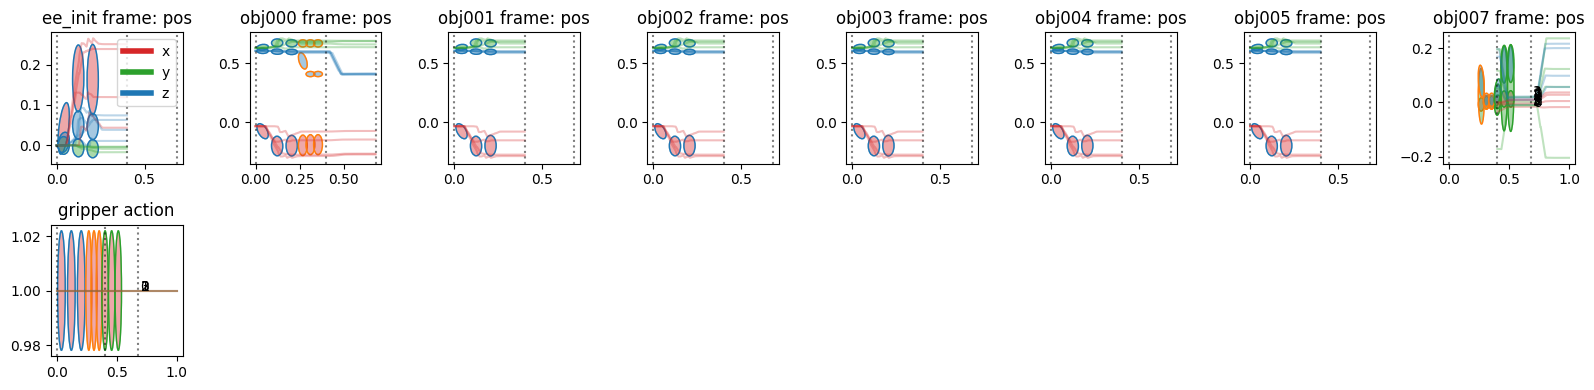

In [27]:
atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=True,
    annotate_gaussians=False, annotate_trajs=True,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False, plot_traj_means=False) #, size=(150, 10))


In [28]:
atpgmm.fit_trajectories(demos, fix_frames=True,
                       fitting_actions=(FittingStage.EM_HMM, ))


2025-07-22 01:19:06.635 | INFO     |  Fitting AutoTPGMM


Fitting segments:   0%|          | 0/3 [00:00<?, ?it/s]

HMM EM:   0%|          | 0/50 [00:00<?, ?it/s]

2025-07-22 01:19:06.839 | INFO     |  HMM EM converged


HMM EM:   0%|          | 0/50 [00:00<?, ?it/s]

HMM EM:   0%|          | 0/50 [00:00<?, ?it/s]

((array([[1.00e+000, 1.00e+000, 1.00e+000, ..., 0.00e+000, 0.00e+000,
          0.00e+000],
         [0.00e+000, 8.94e-232, 2.32e-224, ..., 1.03e-082, 8.31e-087,
          2.40e-089],
         [0.00e+000, 0.00e+000, 0.00e+000, ..., 1.00e+000, 1.00e+000,
          1.00e+000]]),
  array([[1.00e+00, 1.00e+00, 1.00e+00, ..., 0.00e+00, 0.00e+00, 0.00e+00],
         [0.00e+00, 0.00e+00, 0.00e+00, ..., 1.28e-57, 6.96e-61, 1.09e-62],
         [0.00e+00, 0.00e+00, 0.00e+00, ..., 1.00e+00, 1.00e+00, 1.00e+00]]),
  array([[1.00e+000, 1.00e+000, 1.00e+000, ..., 0.00e+000, 0.00e+000,
          0.00e+000],
         [0.00e+000, 2.29e-175, 1.79e-167, ..., 1.00e+000, 1.00e+000,
          1.00e+000],
         [0.00e+000, 0.00e+000, 0.00e+000, ..., 1.00e-301, 4.23e-209,
          2.25e-116]])),
 (8839.126992302037, 1730.1100606278983, 1038.3191743437053))

2025-07-22 01:19:08.247 | INFO     |  Did not specify time_based, deciding automatically.


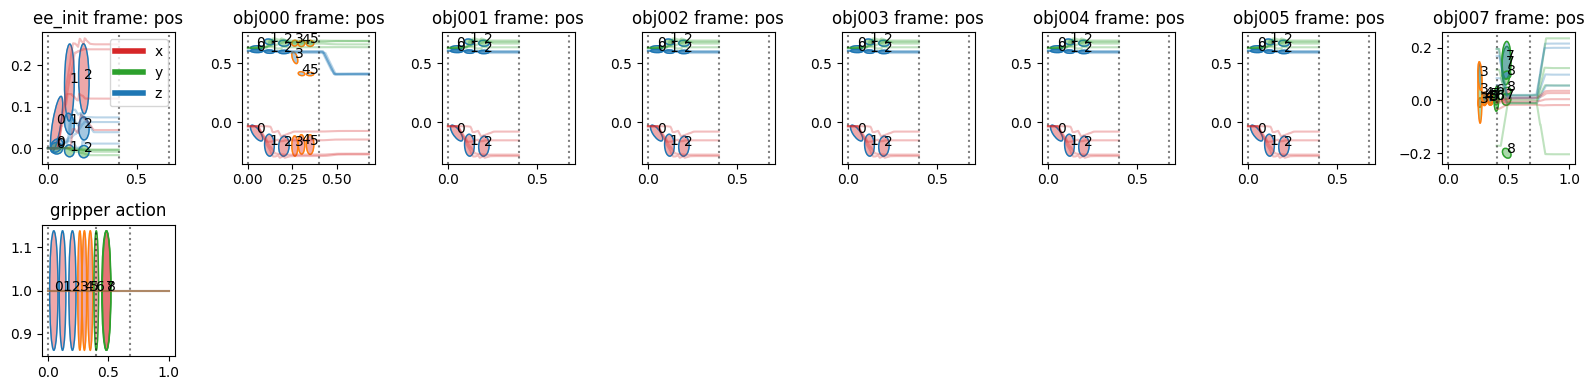

In [29]:

atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=True,
    annotate_gaussians=True, annotate_trajs=False,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False, plot_traj_means=False)

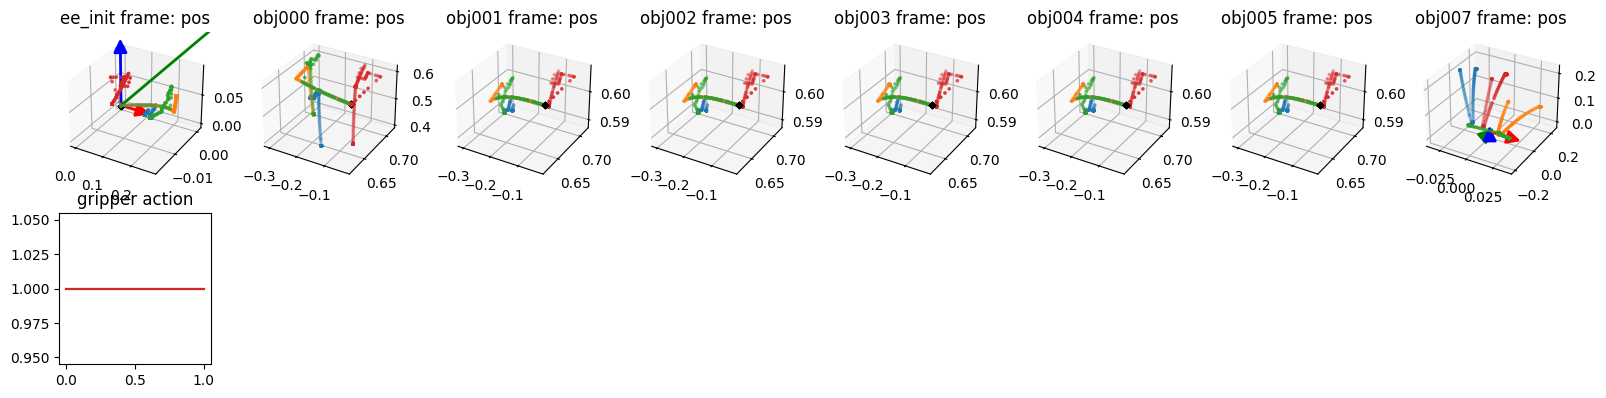

In [30]:
atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=False,
    annotate_gaussians=True, annotate_trajs=False,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False, plot_traj_means=False, time_based=False)

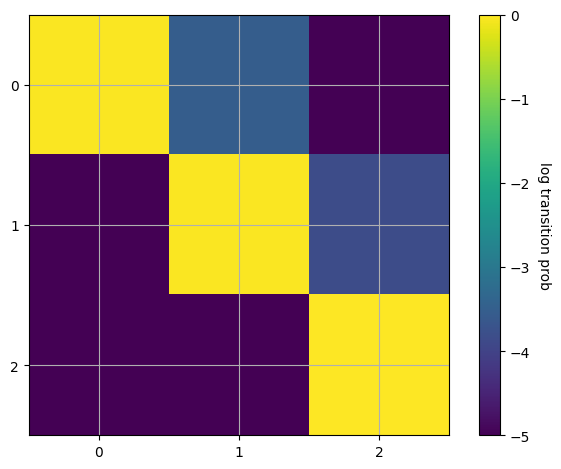

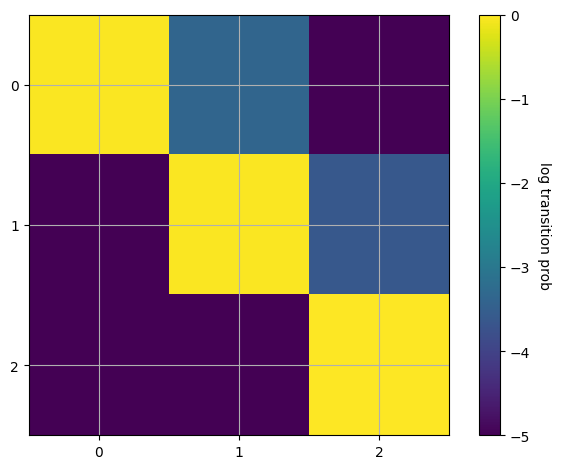

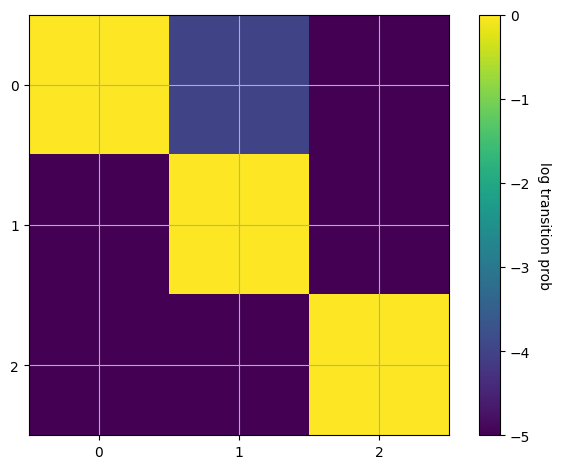

In [31]:
atpgmm.plot_hmm_transition_matrix()

In [32]:
atpgmm.to_disk(data_root / task / 'demos_gmm_policy-release.pt')

In [33]:
seg_local_marginals, seg_trans_marginals, seg_trans_marg_container, seg_joint_models, cascaded_hmms, (reconstructions, original_trajectories, extras) = atpgmm.reconstruct(
    strategy=tapas_gmm.policy.models.tpgmm.ReconstructionStrategy.GMR,
    use_ss=False)


2025-07-22 01:19:14.728 | INFO     |  Caculated segment transition probabilities: (array([[0.29]]), array([[0.42]]))
2025-07-22 01:19:14.729 | INFO     |  Creating partial frame view of demos.


Transforming marginals:   0%|          | 0/4 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/4 [00:00<?, ?it/s]

2025-07-22 01:19:14.888 | INFO     |  Creating partial frame view of demos.


Transforming marginals:   0%|          | 0/4 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/4 [00:00<?, ?it/s]

2025-07-22 01:19:15.082 | INFO     |  Creating partial frame view of demos.


Transforming marginals:   0%|          | 0/4 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/4 [00:00<?, ?it/s]

GMR:   0%|          | 0/4 [00:00<?, ?it/s]

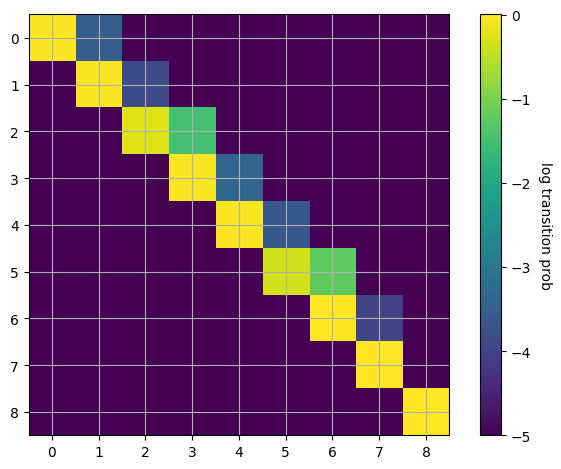

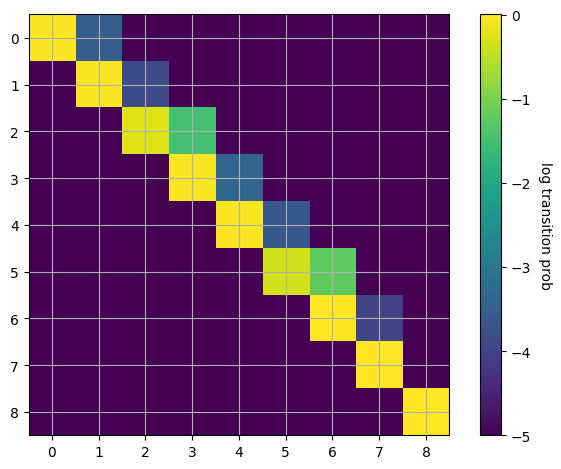

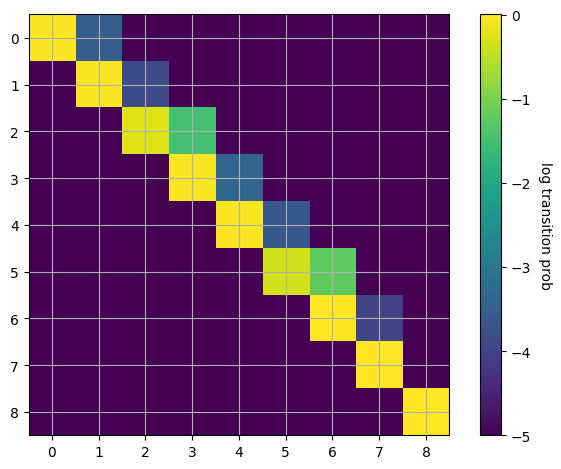

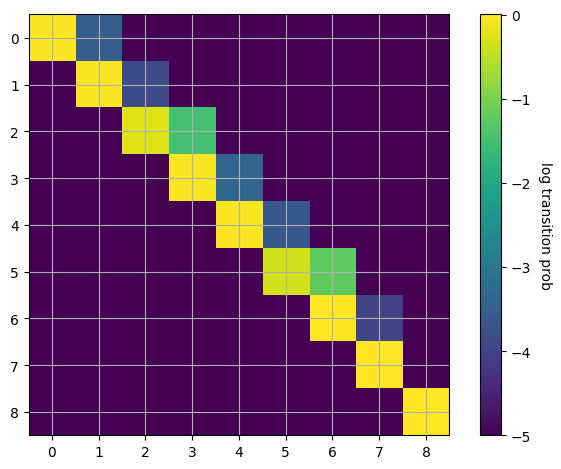

In [34]:
for cascaded_hmm in cascaded_hmms:
    plot_hmm_transition_matrix(cascaded_hmm)

2025-07-22 01:19:18.551 | INFO     |  Taking frame origins from demos.


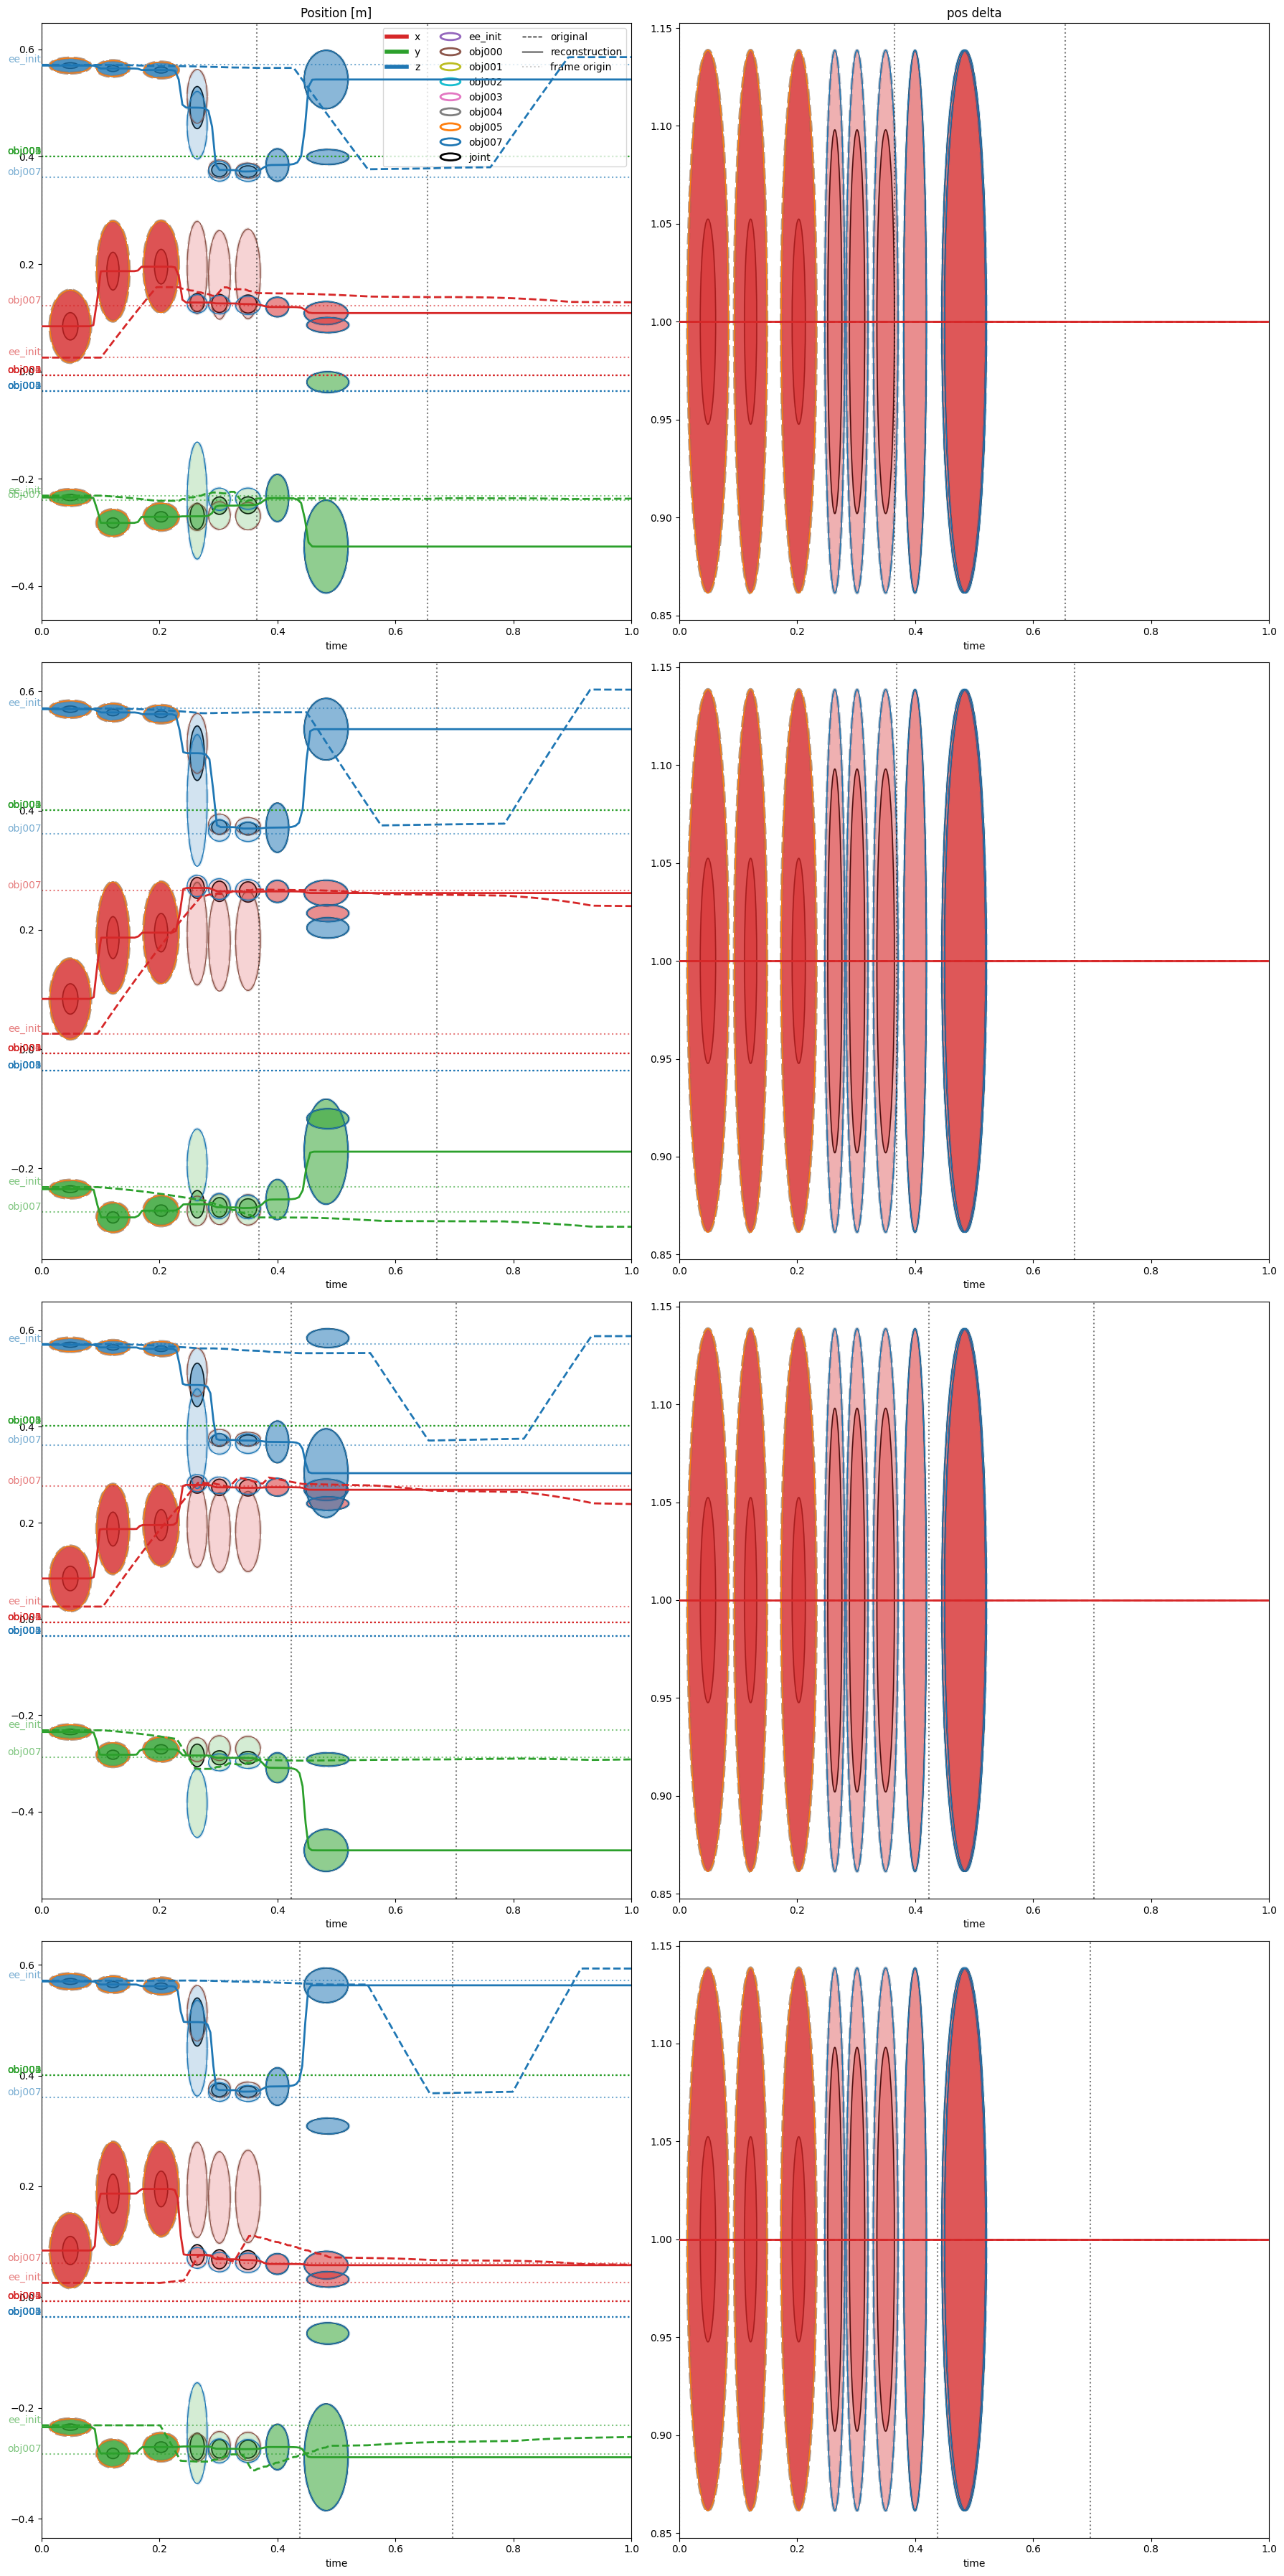

In [35]:

atpgmm.plot_reconstructions(
    seg_trans_marg_container, cascaded_hmms, reconstructions, original_trajectories,
    plot_trajectories=True, plot_reconstructions=True, plot_gaussians=True,
    time_based=True, equal_aspect=False, per_segment=False)


In [36]:
atpgmm.plot_reconstructions(
    seg_trans_marginals, seg_joint_models, reconstructions, original_trajectories,
    plot_trajectories=True, plot_reconstructions=True, plot_gaussians=True,
    time_based=False, equal_aspect=True, per_segment=False)


IndexError: tuple index out of range